 ---
 ---
##**Problem Formulation** 

 ---
 ---



*  **The input:** 
 *  Training dat ( training_data) : it containd the features and the label data.
 *  Testing data (test_data) : it contains the features.

* **the output**
 * it will be the label data (the raiting column) 

*  **Function used**  
 *   classification

 *   predection

*   **Challenges**

 *   The dataset is not clean, and we need some preprocessing depending on the models we choice,
 

*    **the imapct** 
 *   the impact that the model will fits will on the training data and predect well on the test data or any data that we enter, And that will have a huge impact in real life if that uesd we will be able to predect right and proratize what is important.
 
 - we are going to be able to evaluate our mdels correctly and we can help the customer to find what they really want. 


*    **ideal solution**
 *   the ideal solutition happens when our model is able to classify and predict very well on any data the model gets , And also that happens when our data is cleaned perfectly  and 

 - it happens when choose the perfecrt model who can deals with type of dat and not to forget the gyperparameter tuning .


 ---
**the experimental protocol used is 'Hold out method'**

The following is the process of using the hold-out method for model evaluation:

- Split the dataset into two parts

- Train the model on the training dataset; While training the model, some fixed set of hyper parameters is selected.

- Test or evaluate the model on the held-out test dataset
Train the final model on the entire dataset to get a model which can generalize better on the unseen or future dataset. 
---







## **Read the data**

In [1]:
import numpy as np
from tqdm.notebook import tqdm

def read_sdf(file):
    with open(file, 'r') as rf:
        content = rf.read()
    samples = content.split('$$$$')
    
    def parse_sample(s):
        lines = s.splitlines()
        links = []
        nodes = []
        label = 0
        for l in lines:
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0
            if l.startswith('    '):
                feature = l.split()
                node = feature[3]
                nodes.append(node)
            elif l.startswith(' '):
                lnk = l.split()
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):
                    links.append((
                        int(lnk[0])-1, 
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label
    
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]
                
    
        

In [2]:
!pip install --quiet tf2_gnn
from tf2_gnn.layers.gnn import GNN, GNNInput

     |████████████████████████████████| 54 kB 2.0 MB/s 
     |████████████████████████████████| 73 kB 1.4 MB/s 
     |████████████████████████████████| 346 kB 22.1 MB/s 
     |████████████████████████████████| 134 kB 44.4 MB/s 
     |████████████████████████████████| 1.2 MB 19.8 MB/s 
     |████████████████████████████████| 462 kB 43.3 MB/s 
     |████████████████████████████████| 79 kB 5.8 MB/s 
     |████████████████████████████████| 3.6 MB 35.1 MB/s 
     |████████████████████████████████| 178 kB 19.5 MB/s 
     |████████████████████████████████| 85 kB 3.1 MB/s 
     |████████████████████████████████| 41 kB 265 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.11.4 requires typing-extensions<4,>=3.7.4.3, but you have typing-extensions 4.1.1 which is incompatible.


In [3]:
pip install sdf

     |████████████████████████████████| 141 kB 25.5 MB/s 


In [4]:
#read the traing data 
from sklearn.model_selection import train_test_split
training_data = read_sdf('/content/drive/MyDrive/DM_assignment_6/train.sdf')

  0%|          | 0/25024 [00:00<?, ?it/s]

In [5]:
#read the test data 
test_data  = read_sdf("/content/drive/MyDrive/DM_assignment_6/test_x.sdf")

  0%|          | 0/12326 [00:00<?, ?it/s]

In [6]:
 #Splitting traing data 
training_data, validation_set = train_test_split(training_data, test_size=0.15,)

## Visualizing

In [7]:
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 50))

In [8]:
def visualize(sample):
    G=nx.Graph()
    nodes = sample[0]
    edges = sample[1]
    
    labeldict={}
    node_color=[]
    for i,n in enumerate(nodes):
        G.add_node(i)
        labeldict[i]=n
        node_color.append(colors[hash(n)%len(colors)])

    # a list of nodes:
    for e in edges:
        G.add_edge(e[0], e[1])
        
    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()
    
    return G

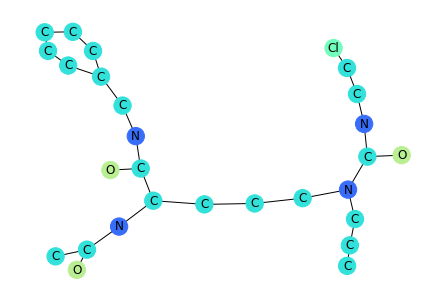

In [9]:
plt.clf()
visualize(training_data[20])

## **plotting** 

In [10]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

##**PreProcessing**

###Toknization

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer

max_vocab = 500
max_len = 100


# build vocabulary from training set
all_nodes = [s[0] for s in training_data]
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
random.seed(0)

def prepare_single_batch(samples):
    sample_nodes = [s[0] for s in samples]
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    sample_nodes = pad_sequences(sample_nodes, padding='post')
    max_nodes_len = np.shape(sample_nodes)[1]
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]
    edges = [e for e in edges if len(e) > 0]
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]
    
    all_nodes = np.reshape(sample_nodes, -1)
    all_edges = np.concatenate(edges)

    node_to_graph = np.reshape(node_to_graph, -1)
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])



def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break


In [13]:
# showing one batch:
for train_batch in gen_batch(training_data, batch_size=4):
    for k,v in train_batch[0].items():
        print(k)
        print(v)
        pass
    print('label', train_batch[1])
    break

data
[2 2 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 2 2 3 3 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 3 3 3 3 3 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 4 2 2 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0]
edges
[[  0   9]
 [  1  15]
 [  2  21]
 [  2  25]
 [  3   9]
 [  3  15]
 [  3  20]
 [  4   5]
 [  4   7]
 [  4  10]
 [  5   6]
 [  5  13]
 [  6   8]
 [  6  11]
 [  7   9]
 [  7  12]
 [  7  17]
 [  8  14]
 [  8  18]
 [ 10  15]
 [ 11  12]
 [ 13  16]
 [ 14  16]
 [ 14  19]
 [ 18  22]
 [ 19  21]
 [ 20  23]
 [ 21  22]
 [ 23  24]
 [ 24  26]
 [ 27  34]
 [ 28  35]
 [ 28  39]
 [ 29  35]
 [ 30  31]
 [ 30  32]
 [ 31  35]
 [ 32  33]
 [ 32  36]
 [ 33  34]
 [ 34  37]
 [ 36  38]
 [ 37  38]
 [ 39  40]
 [ 39  41]
 [ 54  67]
 [ 54  73]
 [ 55  70]
 [ 56  72]
 [ 57  62]
 [ 58  74]
 [ 59  76]
 [ 60  65]
 [ 60  67]
 [ 60  69]
 [ 61  65]
 [ 61  75]
 [ 62  71]
 [ 62  75]
 [ 63  71]
 [ 64  74]
 [ 65  66]
 [ 66  68]
 [ 66  71]
 [ 67  70]
 [ 68  69]
 [ 68  74]
 [ 70  72]
 [ 72  73]
 [ 73  76]

## **Trial_1**

---

###**GNN**

----
GNN include human behavior detection, traffic control, molecular structure study, recommender system, program verification, logical reasoning, social influence prediction, and adversarial attack prevention. Below shows a graph that models the relationships of people in a social network

----
**my plans for this trail**
- i will take this trial as a base line to the next trial, i don't really know how the model going to react and the base mininmum for the accuracy an loss.

----


> 

**Model Hyperparameters**

----
----
- **GNN.get_default_hyperparameters())**. These hyperparameters configure the exact stack of GNN layers:

  - "num_layers" sets the number of GNN message passing layers (usually, a number between 2 and 16)

  - "message_calculation_class" configures the message passing style. This chooses the tf2_gnn.layers.message_passing.* layer used in each step.





- node_features= embeded 
  - the first input contains a vector of the words after we change it by using the function Embadding 
  >

- adjacency_lists=(edge)
  - the edges are what conects one nodes , their dimention is an arry of two values .
>

- node_to_graph_map=node2graph
  - shows how max_nodes_len,number of edges on one batch 
>
- num_graphs=num_graph
  - number of samples

- **Epochs** : indicates the number of passes of the entire training dataset   the machine learning algorithm has completed
 >
- **batch_size**: the number of training examples in one forward/backward pass.

>
- **hidden_dim** : sets the size of the output of all message passing layers.



In [ ]:
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

data = keras.Input(batch_shape=(None,))

edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 8
# parameter message calcualation class
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 8), dtype=tf.float32, name=None), name='gnn_1/StatefulPartitionedCall:0', description="created by layer 'gnn_1'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 8), dtype=tf.float32, name=None), name='tf.math.segment_mean_1/SegmentMean:0', description="created by layer 'tf.math.segment_mean_1'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_1/Sigmoid:0', description="created by layer 'dense_1'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []          

In [ ]:
#compile the model
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
#fit the mdel
import math

batch_size = 32
num_batchs = math.ceil(len(training_data) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history = model.fit(
    gen_batch(
        training_data, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 8), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape:0", shape=(None, 8), dtype=float32), dense_shape=Tensor("gradients/rgcn_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor o

665/665 [==============================] - 17s 21ms/step - loss: 0.3296 - auc: 0.4099 - val_loss: 0.2512 - val_auc: 0.3682
Epoch 2/30
665/665 [==============================] - 13s 19ms/step - loss: 0.2454 - auc: 0.3619 - val_loss: 0.2361 - val_auc: 0.3841
Epoch 3/30
665/665 [==============================] - 13s 19ms/step - loss: 0.2321 - auc: 0.3750 - val_loss: 0.2256 - val_auc: 0.3883
Epoch 4/30
665/665 [==============================] - 13s 20ms/step - loss: 0.2195 - auc: 0.3777 - val_loss: 0.2084 - val_auc: 0.3961
Epoch 5/30
665/665 [==============================] - 14s 21ms/step - loss: 0.2054 - auc: 0.4246 - val_loss: 0.1988 - val_auc: 0.5251
Epoch 6/30
665/665 [==============================] - 13s 19ms/step - loss: 0.1952 - auc: 0.5587 - val_loss: 0.1918 - val_auc: 0.5857
Epoch 7/30
665/665 [==============================] - 14s 22ms/step - loss: 0.1927 - auc: 0.5831 - val_loss: 0.1968 - val_auc: 0.6337
Epoch 8/30
665/665 [==============================] - 13s 20ms/step - los

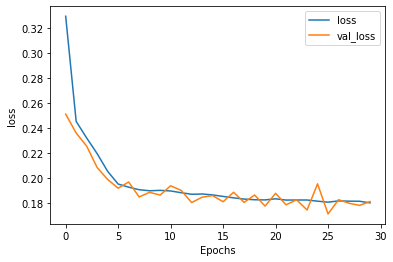

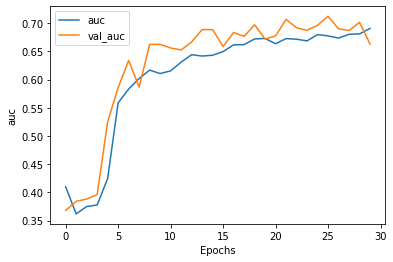

In [ ]:
#showing the loss and val_los from the training data
plot_graphs(history, "loss")
#showing accuracy and val_accuracy from the training data 
plot_graphs(history, "auc")

In [ ]:
y_pred = model.predict(
    gen_batch(test_data, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [ ]:
len(y_pred)

12326

In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('/content/drive/MyDrive/DM_assignment_6/output.csv')

----
- **Ater performing the model we ralize that the model perform well there is no overfitting or underfitting.** 

----

## **Trial_2**

----

### **GGNN**

e Gated Graph Neural Networks (GG-NNs), our adaptation of GNNs that is suitable
for non-sequential outputs. We will describe sequential outputs in the next section. The biggest modification of GNNs is that we use Gated Recurrent Units.

-----
**My plas for this trail**:
>
From the previous trial we realize that the model perform well based on the accuracy and the loss. so in this trial im planning to use GGNN which is an adaptation of GNNs so i predect the model will give a higher accuracy and improvment in the accuracy overall.

----

**Model Hyperparameters**

----
----
\
- **GNN.get_default_hyperparameters())**. These hyperparameters configure the exact stack of GNN layers:

  - "num_layers" sets the number of GNN message passing layers (usually, a number between 2 and 16)

  - "message_calculation_class" configures the message passing style. This chooses the tf2_gnn.layers.message_passing.* layer used in each step.

- **params["num_aggr_MLP_HIDDEN_LAYERS"]** : this is a new hyperparameter used witht thie layer

- **params['message_calculation_class']= 'GGNN'** : to chose the new methon.

- **params['num_heads']=4** : to choose the number of heads 

\
___

- node_features= embeded 
  - the first input contains a vector of the words after we change it by using the function Embadding 
  >

- adjacency_lists=(edge)
  - the edges are what conects one nodes , their dimention is an arry of two values .
>

- node_to_graph_map=node2graph
  - shows how max_nodes_len,number of edges on one batch 
>
- num_graphs=num_graph
  - number of samples

- **Epochs** : indicates the number of passes of the entire training dataset   the machine learning algorithm has completed
 >
- **batch_size**: the number of training examples in one forward/backward pass.

>
- **hidden_dim** : sets the size of the output of all message passing layers.

-----

In [ ]:
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

data = keras.Input(batch_shape=(None,))


edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)


params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 64
params["num_aggr_MLP_HIDDEN_LAYERS"] = 32
params['message_calculation_class']= 'GGNN'
params['num_heads']= 4
gnn_layer = GNN(params)

gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)


avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_2/StatefulPartitionedCall:0', description="created by layer 'gnn_2'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_2/SegmentMean:0', description="created by layer 'tf.math.segment_mean_2'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_2/Sigmoid:0', description="created by layer 'dense_2'")
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None,)]            0           []        

In [ ]:
#compile the model
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
#fit the model
import math

batch_size = 50
num_batchs = math.ceil(len(training_data) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history = model.fit(
    gen_batch(
        training_data, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=50, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/ggnn_3/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_2/embedding_lookup_grad/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/ggnn_2/embedding_lookup_grad/Cast:0", s

426/426 [==============================] - 19s 36ms/step - loss: 0.1975 - auc: 0.5955 - val_loss: 0.1869 - val_auc: 0.6582
Epoch 2/30
426/426 [==============================] - 14s 33ms/step - loss: 0.1870 - auc: 0.6417 - val_loss: 0.1863 - val_auc: 0.6721
Epoch 3/30
426/426 [==============================] - 14s 32ms/step - loss: 0.1848 - auc: 0.6613 - val_loss: 0.1928 - val_auc: 0.6411
Epoch 4/30
426/426 [==============================] - 14s 32ms/step - loss: 0.1844 - auc: 0.6651 - val_loss: 0.1895 - val_auc: 0.6601
Epoch 5/30
426/426 [==============================] - 14s 32ms/step - loss: 0.1789 - auc: 0.7051 - val_loss: 0.1710 - val_auc: 0.7185
Epoch 6/30
426/426 [==============================] - 14s 33ms/step - loss: 0.1741 - auc: 0.7300 - val_loss: 0.1841 - val_auc: 0.7044
Epoch 7/30
426/426 [==============================] - 14s 33ms/step - loss: 0.1711 - auc: 0.7456 - val_loss: 0.1664 - val_auc: 0.7388
Epoch 8/30
426/426 [==============================] - 14s 33ms/step - los

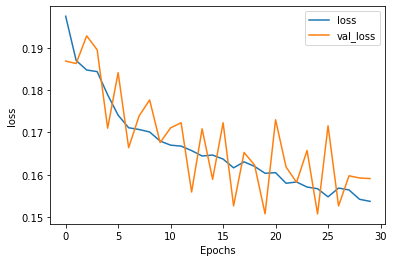

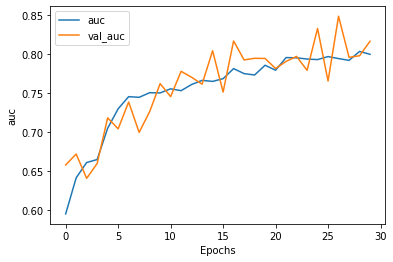

In [ ]:
#showing the loss and val_los from the training data
plot_graphs(history, "loss")
#showing accuracy and val_accuracy from the training data 
plot_graphs(history, "auc")

In [ ]:
y_pred = model.predict(
    gen_batch(test_data, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('/content/drive/MyDrive/DM_assignment_6/output.csv')

----
- **Ater performing the model we ralize that the model perform vert well comparing to the previous trial and this is expected, there is no overfitting or underfitting.** 

----

## **Trial_3**

----

### **RGCN**

Graph Convolutional Networks (GCNs), a powerful type of neural network designed to work directly on graphs and leverage their structural information.

GCNs are a very powerful neural network architecture for machine learning on graphs. In fact, they are so powerful that even a randomly initiated 2-layer GCN can produce useful feature representations of nodes in networks. The figure below illustrates a 2-dimensional representation of each node in a network produced by such a GCN. Notice that the relative nearness of nodes in the network is preserved in the 2-dimensional representation even without any training.

-----
**My plas for this trail**:
>
From the previous trial we realize that the model perform well based on the accuracy and the loss. so in this trial im planning to use RGCN As a message calculation class.

----

**Model Hyperparameters**

----
----
\
- **GNN.get_default_hyperparameters())**. These hyperparameters configure the exact stack of GNN layers:

  - "num_layers" sets the number of GNN message passing layers (usually, a number between 2 and 16)

  - "message_calculation_class" configures the message passing style. This chooses the tf2_gnn.layers.message_passing.* layer used in each step.

- **params["num_aggr_MLP_HIDDEN_LAYERS"]=32** : this is a new hyperparameter used witht thie layer

- **params['message_calculation_class']= 'RGCN'** : to chose the new methon.



\
___

- node_features= embeded 
  - the first input contains a vector of the words after we change it by using the function Embadding 
  >

- adjacency_lists=(edge)
  - the edges are what conects one nodes , their dimention is an arry of two values .
>

- node_to_graph_map=node2graph
  - shows how max_nodes_len,number of edges on one batch 
>
- num_graphs=num_graph
  - number of samples

- **Epochs** : indicates the number of passes of the entire training dataset   the machine learning algorithm has completed
 >
- **batch_size**: the number of training examples in one forward/backward pass.

>
- **hidden_dim**= 64 : sets the size of the output of all message passing layers.

-----

In [ ]:
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

data = keras.Input(batch_shape=(None,))

edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)


params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 64
params["num_aggr_MLP_HIDDEN_LAYERS"] = 32
params['message_calculation_class']= 'RGCN'
gnn_layer = GNN(params)

gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)


avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_3/StatefulPartitionedCall:0', description="created by layer 'gnn_3'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_3/SegmentMean:0', description="created by layer 'tf.math.segment_mean_3'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_3/Sigmoid:0', description="created by layer 'dense_3'")
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None,)]            0           []        

In [ ]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
import math

batch_size = 50
num_batchs = math.ceil(len(training_data) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history = model.fit(
    gen_batch(
        training_data, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=50, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/rgcn_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor

426/426 [==============================] - 14s 26ms/step - loss: 0.2320 - auc: 0.5165 - val_loss: 0.2355 - val_auc: 0.6472
Epoch 2/30
426/426 [==============================] - 10s 24ms/step - loss: 0.1942 - auc: 0.6300 - val_loss: 0.2002 - val_auc: 0.6312
Epoch 3/30
426/426 [==============================] - 10s 24ms/step - loss: 0.1900 - auc: 0.6512 - val_loss: 0.1873 - val_auc: 0.6802
Epoch 4/30
426/426 [==============================] - 10s 25ms/step - loss: 0.1872 - auc: 0.6679 - val_loss: 0.1799 - val_auc: 0.7013
Epoch 5/30
426/426 [==============================] - 10s 25ms/step - loss: 0.1854 - auc: 0.6704 - val_loss: 0.1803 - val_auc: 0.6870
Epoch 6/30
426/426 [==============================] - 10s 25ms/step - loss: 0.1837 - auc: 0.6846 - val_loss: 0.1774 - val_auc: 0.7207
Epoch 7/30
426/426 [==============================] - 10s 25ms/step - loss: 0.1807 - auc: 0.7017 - val_loss: 0.1816 - val_auc: 0.6844
Epoch 8/30
426/426 [==============================] - 10s 25ms/step - los

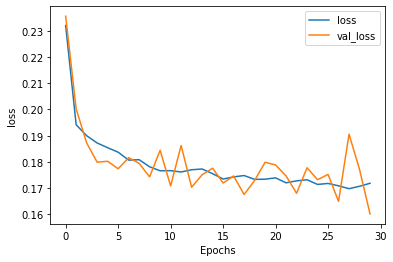

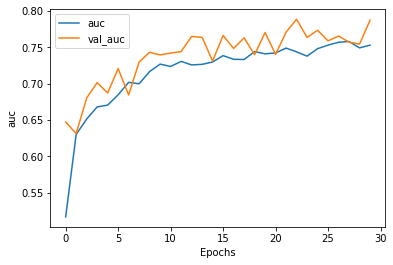

In [ ]:
#showing the loss and val_los from the training data
plot_graphs(history, "loss")
#showing accuracy and val_accuracy from the training data 
plot_graphs(history, "auc")

In [ ]:
y_pred = model.predict(
    gen_batch(test_data, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('/content/drive/MyDrive/DM_assignment_6/output.csv')

----
- **Ater performing the model we ralize that the model perform well comparing to the previous trial and this is expected, there is no overfitting or underfitting.** 

----

## **Trial_4**

---

### **RGAT**

Graph attention networks (GATs), novel convolution-style neural networks that
operate on graph-structured data, leveraging masked self-attentional layers. The graph attentional
layer utilized throughout these networks is computationally efficient (does not require costly matrix operations, and is parallelizable across all nodes in the graph)

-----

**My plas for this trail**:
>
From the previous trial we realize that the model perform well based on the accuracy and the loss. so in this trial im planning to use RGAT As a message calculation class.

----

**Model Hyperparameters**

----
----
\
- **GNN.get_default_hyperparameters())**. These hyperparameters configure the exact stack of GNN layers:

  - "num_layers" sets the number of GNN message passing layers (usually, a number between 2 and 16)

  - "message_calculation_class" configures the message passing style. This chooses the tf2_gnn.layers.message_passing.* layer used in each step.

- **params["num_aggr_MLP_HIDDEN_LAYERS"]=32** : this is a new hyperparameter used witht thie layer

- **params['message_calculation_class']= 'RGAT'** : to chose the new methon.

\
___

- node_features= embeded 
  - the first input contains a vector of the words after we change it by using the function Embadding 
  >

- adjacency_lists=(edge)
  - the edges are what conects one nodes , their dimention is an arry of two values .
>

- node_to_graph_map=node2graph
  - shows how max_nodes_len,number of edges on one batch 
>
- num_graphs=num_graph
  - number of samples

- **Epochs** : indicates the number of passes of the entire training dataset   the machine learning algorithm has completed
 >
- **batch_size**: the number of training examples in one forward/backward pass.

>
- **hidden_dim**= 64 : sets the size of the output of all message passing layers.

-----

In [ ]:
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

data = keras.Input(batch_shape=(None,))

edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)


params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 64
params["num_aggr_MLP_HIDDEN_LAYERS"] = 32
params['message_calculation_class']= 'RGAT'
params['num_heads']= 4
gnn_layer = GNN(params)

gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)


avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_4/StatefulPartitionedCall:0', description="created by layer 'gnn_4'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_4/SegmentMean:0', description="created by layer 'tf.math.segment_mean_4'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_4/Sigmoid:0', description="created by layer 'dense_4'")
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None,)]            0           []        

In [ ]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
import math

batch_size = 50
num_batchs = math.ceil(len(training_data) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history = model.fit(
    gen_batch(
        training_data, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=50, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amo

426/426 [==============================] - 24s 44ms/step - loss: 0.2391 - auc: 0.4852 - val_loss: 0.2024 - val_auc: 0.6298
Epoch 2/30
426/426 [==============================] - 18s 42ms/step - loss: 0.1955 - auc: 0.6119 - val_loss: 0.1914 - val_auc: 0.6495
Epoch 3/30
426/426 [==============================] - 18s 42ms/step - loss: 0.1897 - auc: 0.6614 - val_loss: 0.2111 - val_auc: 0.6956
Epoch 4/30
426/426 [==============================] - 18s 42ms/step - loss: 0.1871 - auc: 0.6770 - val_loss: 0.1888 - val_auc: 0.6733
Epoch 5/30
426/426 [==============================] - 18s 42ms/step - loss: 0.1833 - auc: 0.6987 - val_loss: 0.1941 - val_auc: 0.7079
Epoch 6/30
426/426 [==============================] - 18s 42ms/step - loss: 0.1805 - auc: 0.7043 - val_loss: 0.1768 - val_auc: 0.7231
Epoch 7/30
426/426 [==============================] - 18s 42ms/step - loss: 0.1784 - auc: 0.7155 - val_loss: 0.1777 - val_auc: 0.7377
Epoch 8/30
426/426 [==============================] - 18s 42ms/step - los

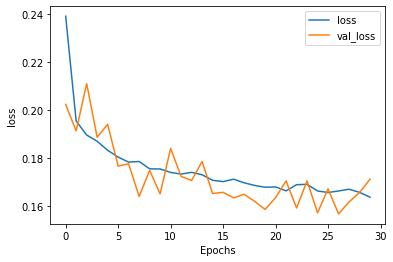

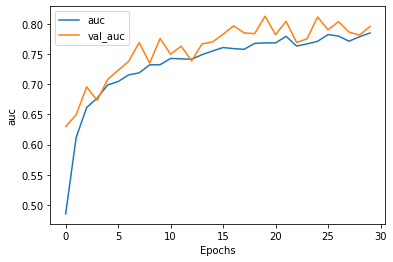

In [ ]:
#showing the loss and val_los from the training data
plot_graphs(history, "loss")
#showing accuracy and val_accuracy from the training data 
plot_graphs(history, "auc")

In [ ]:
y_pred = model.predict(
    gen_batch(test_data, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('/content/drive/MyDrive/DM_assignment_6/output.csv')

----
- **Ater performing the model we ralize that the model perform vert well comparing to the previous trial and this is expected, there is no overfitting or underfitting.** 

----

## **Trial_5**


----

### **RGIN**

**My plas for this trail**:
>
From the previous trial we realize that the model perform well based on the accuracy and the loss. so in this trial im planning to use RGIN As a message calculation class.

----

**Model Hyperparameters**

----
----
\
- **GNN.get_default_hyperparameters())**. These hyperparameters configure the exact stack of GNN layers:

  - "num_layers" sets the number of GNN message passing layers (usually, a number between 2 and 16)

  - "message_calculation_class" configures the message passing style. This chooses the tf2_gnn.layers.message_passing.* layer used in each step.

- **params["num_aggr_MLP_HIDDEN_LAYERS"]=32** : this is a new hyperparameter used witht thie layer

- **params['message_calculation_class']= 'RGIN'** : to chose the new methon.

\
___

- node_features= embeded 
  - the first input contains a vector of the words after we change it by using the function Embadding 
  >

- adjacency_lists=(edge)
  - the edges are what conects one nodes , their dimention is an arry of two values .
>

- node_to_graph_map=node2graph
  - shows how max_nodes_len,number of edges on one batch 
>
- num_graphs=num_graph
  - number of samples

- **Epochs** : indicates the number of passes of the entire training dataset   the machine learning algorithm has completed
 >
- **batch_size**: the number of training examples in one forward/backward pass.

>
- **hidden_dim**= 64 : sets the size of the output of all message passing layers.

-----

In [ ]:
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

data = keras.Input(batch_shape=(None,))

edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)


params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 64
params["num_aggr_MLP_hidden_layers"] = 32
params['message_calculation_class']= 'RGIN'

gnn_layer = GNN(params)

gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)


avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_5/StatefulPartitionedCall:0', description="created by layer 'gnn_5'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_5/SegmentMean:0', description="created by layer 'tf.math.segment_mean_5'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_5/Sigmoid:0', description="created by layer 'dense_5'")
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None,)]            0           []        

In [ ]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
import math

batch_size = 30
num_batchs = math.ceil(len(training_data) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history = model.fit(
    gen_batch(
        training_data, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=30, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgin_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgin_2/embedding_lookup_grad/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/rgin_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor

709/709 [==============================] - 53s 57ms/step - loss: 0.2946 - auc: 0.4554 - val_loss: 0.1966 - val_auc: 0.6345
Epoch 2/30
709/709 [==============================] - 39s 55ms/step - loss: 0.2353 - auc: 0.5345 - val_loss: 0.2013 - val_auc: 0.6140
Epoch 3/30
709/709 [==============================] - 39s 56ms/step - loss: 0.2199 - auc: 0.5612 - val_loss: 0.2044 - val_auc: 0.6131
Epoch 4/30
709/709 [==============================] - 39s 56ms/step - loss: 0.2156 - auc: 0.5608 - val_loss: 0.2193 - val_auc: 0.6569
Epoch 5/30
709/709 [==============================] - 39s 56ms/step - loss: 0.2109 - auc: 0.5663 - val_loss: 0.2196 - val_auc: 0.6638
Epoch 6/30
709/709 [==============================] - 39s 55ms/step - loss: 0.2009 - auc: 0.6036 - val_loss: 0.1867 - val_auc: 0.6781
Epoch 7/30
709/709 [==============================] - 39s 55ms/step - loss: 0.1986 - auc: 0.6147 - val_loss: 0.2122 - val_auc: 0.6902
Epoch 8/30
709/709 [==============================] - 39s 56ms/step - los

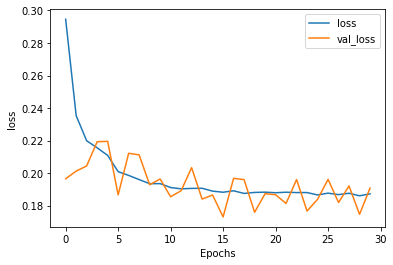

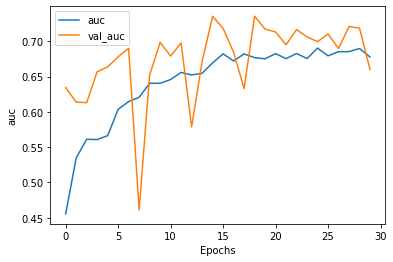

In [ ]:
#showing the loss and val_los from the training data
plot_graphs(history, "loss")
#showing accuracy and val_accuracy from the training data 
plot_graphs(history, "auc")

In [ ]:
y_pred = model.predict(
    gen_batch(test_data, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('/content/drive/MyDrive/DM_assignment_6/output.csv')

----
- **Ater performing the model we ralize that the model perform well comparing to the previous trial and this is expected, there is no overfitting or underfitting.** 

----

# **Up sampling**

-----
**We realize that the datais very unbalanced** 

------

##**Pre-processing**

###**Read the data**

In [ ]:
#Reading traing data 
training_data = read_sdf('/content/drive/MyDrive/DM_assignment_6/train.sdf')

  0%|          | 0/25024 [00:00<?, ?it/s]

In [ ]:
import pandas as pd

df_train=pd.DataFrame(training_data,columns=["nodes","edge","label"])
df_train

,nodes,edge,label
0,"[S, O, O, O, O, N, N, N, C, C, C, C, C, C, C, ...","[[0, 8], [0, 14], [1, 10], [2, 11], [3, 7], [4...",0
1,"[O, O, O, O, O, O, N, N, N, C, C, C, C, C, C, ...","[[0, 6], [0, 15], [1, 15], [2, 7], [3, 8], [4,...",0
2,"[F, F, F, O, O, O, O, O, N, N, C, C, C, C, C, ...","[[0, 19], [1, 19], [2, 19], [3, 16], [4, 28], ...",0
3,"[Cl, S, S, O, O, O, O, N, N, N, N, C, C, C, C,...","[[0, 12], [1, 15], [1, 18], [2, 4], [2, 5], [2...",0
4,"[S, O, O, N, N, N, N, N, N, C, C, C, C, C, C, ...","[[0, 1], [0, 2], [0, 5], [0, 9], [3, 4], [3, 1...",0
...,...,...,...
25019,"[O, O, O, O, O, O, N, N, C, C, C, C, C, C, C, ...","[[0, 8], [0, 14], [1, 10], [2, 12], [3, 13], [...",0
25020,"[O, O, O, O, O, N, C, C, C, C, C, C, C, C, C, ...","[[0, 9], [1, 11], [2, 16], [2, 19], [3, 16], [...",0
25021,"[O, O, O, O, O, O, O, O, O, N, C, C, C, C, C, ...","[[0, 12], [0, 16], [1, 10], [2, 11], [3, 15], ...",0
25022,"[S, O, O, O, O, N, N, N, C, C, C, C, C, C, C, ...","[[0, 11], [0, 12], [1, 21], [1, 27], [2, 22], ...",0


### Upsampling 

In [ ]:
#upsampling the label data 
df_class0 = df_train[df_train["label"]==0]
df_class1 = df_train[df_train["label"]==1]

print(df_class0.shape)
print(df_class1.shape)

(23806, 3)
(1218, 3)


In [ ]:
from sklearn.utils import resample
df_class1_upsample = resample(df_class1, replace=True, n_samples=len(df_class0), random_state=42)
print(df_class1_upsample)

                                                   nodes  \
23357  [O, O, O, O, O, C, C, C, C, C, C, C, C, C, C, ...   
17640  [O, O, O, O, O, O, O, C, C, C, C, C, C, C, C, ...   
23463  [O, O, N, N, C, C, C, C, C, C, C, C, C, C, C, ...   
22676  [O, O, O, O, O, O, O, C, C, C, C, C, C, C, C, ...   
21324  [S, S, O, O, O, O, N, N, C, C, C, C, C, C, C, ...   
...                                                  ...   
16643  [O, O, O, O, O, O, N, C, C, C, C, C, C, C, C, ...   
5670   [Cl, O, O, O, O, O, O, O, O, N, N, N, N, C, C,...   
4221   [Cl, Cl, O, O, O, O, N, N, N, C, C, C, C, C, C...   
14241  [Cl, O, O, O, O, O, O, O, O, O, O, C, C, C, C,...   
19722               [O, O, O, O, N, N, N, C, C, C, C, C]   

                                                    edge  label  
23357  [[8, 0], [0, 19], [1, 17], [1, 22], [2, 19], [...      1  
17640  [[7, 0], [8, 0], [1, 14], [1, 15], [11, 2], [1...      1  
23463  [[0, 5], [1, 4], [2, 4], [2, 5], [2, 6], [3, 4...      1  
22676  [[0, 9],

In [ ]:
df_upsample =pd.concat([df_class0,df_class1_upsample])
print(df_upsample["label"].value_counts())

0    23806
1    23806
Name: label, dtype: int64


In [ ]:
df_upsampling = df_upsample.to_numpy()

In [ ]:
#Splitting traing data 
training_data, validation_set = train_test_split(df_upsampling, test_size=0.15,)

In [ ]:
# training_data


###Toknization

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

max_vocab = 500
max_len = 100


# build vocabulary from training set
all_nodes = [s[0] for s in training_data]
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

## **Trial_6**

----

### **RGAT**

In [ ]:
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

data = keras.Input(batch_shape=(None,))


edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)


params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 64
params["num_aggr_MLP_HIDDEN_LAYERS"] = 32
params['message_calculation_class']= 'RGAT'
params['num_heads']= 4
gnn_layer = GNN(params)

gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)


avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

In [ ]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
import math

batch_size = 30
num_batchs = math.ceil(len(training_data) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history = model.fit(
    gen_batch(
        training_data, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=30, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amo

1349/1349 [==============================] - 99s 69ms/step - loss: 0.6186 - auc: 0.7172 - val_loss: 0.5940 - val_auc: 0.7580
Epoch 2/30
1349/1349 [==============================] - 93s 69ms/step - loss: 0.5805 - auc: 0.7663 - val_loss: 0.5685 - val_auc: 0.7796
Epoch 3/30
1349/1349 [==============================] - 93s 69ms/step - loss: 0.5589 - auc: 0.7900 - val_loss: 0.5446 - val_auc: 0.8025
Epoch 4/30
1349/1349 [==============================] - 94s 70ms/step - loss: 0.5346 - auc: 0.8106 - val_loss: 0.5161 - val_auc: 0.8254
Epoch 5/30
1349/1349 [==============================] - 93s 69ms/step - loss: 0.5158 - auc: 0.8255 - val_loss: 0.5085 - val_auc: 0.8359
Epoch 6/30
1349/1349 [==============================] - 93s 69ms/step - loss: 0.4996 - auc: 0.8388 - val_loss: 0.4935 - val_auc: 0.8488
Epoch 7/30
1349/1349 [==============================] - 111s 82ms/step - loss: 0.4850 - auc: 0.8494 - val_loss: 0.4780 - val_auc: 0.8599
Epoch 8/30
1349/1349 [==============================] - 95

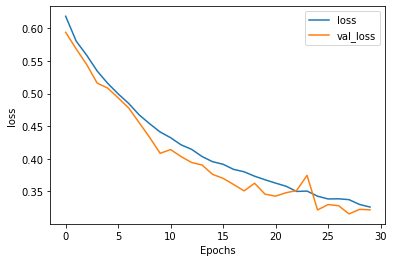

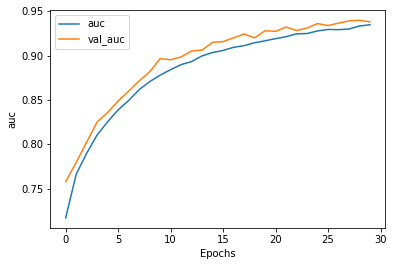

In [ ]:
#showing the loss and val_los from the training data
plot_graphs(history, "loss")
#showing accuracy and val_accuracy from the training data 
plot_graphs(history, "auc")

In [ ]:
y_pred = model.predict(
    gen_batch(test_data, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [ ]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('/content/drive/MyDrive/DM_assignment_6/output.csv')

## **Trial_7**

___

----
- **Ater performing the model we ralize that the model perform very very well comparing to the previous trial and this is expected, there is no overfitting or underfitting.** it's considered the best model we can realoze an obvious improvment in the performance of the model.

----

### **GGNN**

In [14]:
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

data = keras.Input(batch_shape=(None,))

edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)


params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 64
params["num_aggr_MLP_HIDDEN_LAYERS"] = 32
params['message_calculation_class']= 'GGNN'
params['num_heads']= 4
gnn_layer = GNN(params)

gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)


avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

In [15]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [16]:
import math

batch_size = 30
num_batchs = math.ceil(len(training_data) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history = model.fit(
    gen_batch(
        training_data, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=30, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/ggnn_3/embedding_lookup_grad/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/ggnn_3/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/GatherV2_1_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/GatherV2_1_grad/Reshape:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradients/GatherV2_1_grad/Cast:0", shape=(1,), dtype=int32))) to a dense Tenso

709/709 [==============================] - 93s 118ms/step - loss: 0.1979 - auc: 0.6121 - val_loss: 0.1646 - val_auc: 0.6721
Epoch 2/30
709/709 [==============================] - 67s 94ms/step - loss: 0.1891 - auc: 0.6586 - val_loss: 0.1633 - val_auc: 0.6760
Epoch 3/30
709/709 [==============================] - 74s 104ms/step - loss: 0.1859 - auc: 0.6800 - val_loss: 0.1607 - val_auc: 0.7057
Epoch 4/30
709/709 [==============================] - 67s 94ms/step - loss: 0.1846 - auc: 0.6933 - val_loss: 0.1601 - val_auc: 0.7008
Epoch 5/30
709/709 [==============================] - 66s 94ms/step - loss: 0.1825 - auc: 0.7030 - val_loss: 0.1561 - val_auc: 0.7210
Epoch 6/30
709/709 [==============================] - 67s 94ms/step - loss: 0.1768 - auc: 0.7353 - val_loss: 0.1607 - val_auc: 0.7452
Epoch 7/30
709/709 [==============================] - 67s 94ms/step - loss: 0.1723 - auc: 0.7579 - val_loss: 0.1509 - val_auc: 0.7282
Epoch 8/30
709/709 [==============================] - 67s 94ms/step - l

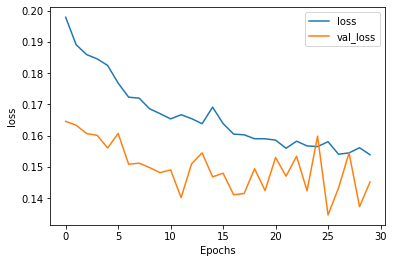

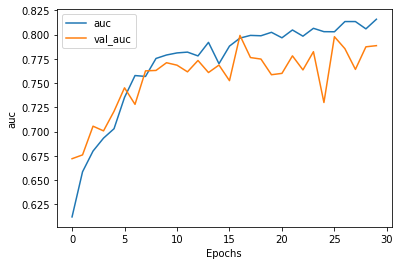

In [17]:
#showing the loss and val_los from the training data
plot_graphs(history, "loss")
#showing accuracy and val_accuracy from the training data 
plot_graphs(history, "auc")

In [18]:
y_pred = model.predict(
    gen_batch(test_data, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [19]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('/content/drive/MyDrive/DM_assignment_6/output.csv')

----
- **Ater performing the model we ralize that the model perform well comparing to the previous trial and this is expected, there is no overfitting or underfitting.** 

----

## **Trial_8**

----

### **RGCN**

Graph Convolutional Networks (GCNs), a powerful type of neural network designed to work directly on graphs and leverage their structural information.

GCNs are a very powerful neural network architecture for machine learning on graphs. In fact, they are so powerful that even a randomly initiated 2-layer GCN can produce useful feature representations of nodes in networks. The figure below illustrates a 2-dimensional representation of each node in a network produced by such a GCN. Notice that the relative nearness of nodes in the network is preserved in the 2-dimensional representation even without any training.

In [20]:
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

data = keras.Input(batch_shape=(None,))


edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)


params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 64
params["num_aggr_MLP_HIDDEN_LAYERS"] = 32
params['message_calculation_class']= 'RGCN'
gnn_layer = GNN(params)

gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)


avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_1/StatefulPartitionedCall:0', description="created by layer 'gnn_1'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_1/SegmentMean:0', description="created by layer 'tf.math.segment_mean_1'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_1/Sigmoid:0', description="created by layer 'dense_1'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []        

In [21]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [22]:
import math

batch_size = 50
num_batchs = math.ceil(len(training_data) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history =model.fit(
    gen_batch(
        training_data, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=50, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/rgcn_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor

426/426 [==============================] - 39s 85ms/step - loss: 0.2398 - auc: 0.5040 - val_loss: 0.1804 - val_auc: 0.6423
Epoch 2/30
426/426 [==============================] - 36s 84ms/step - loss: 0.1992 - auc: 0.6135 - val_loss: 0.3192 - val_auc: 0.6607
Epoch 3/30
426/426 [==============================] - 35s 83ms/step - loss: 0.1923 - auc: 0.6474 - val_loss: 0.1669 - val_auc: 0.6497
Epoch 4/30
426/426 [==============================] - 36s 84ms/step - loss: 0.1916 - auc: 0.6481 - val_loss: 0.1677 - val_auc: 0.7085
Epoch 5/30
426/426 [==============================] - 36s 85ms/step - loss: 0.1873 - auc: 0.6772 - val_loss: 0.1721 - val_auc: 0.7143
Epoch 6/30
426/426 [==============================] - 36s 85ms/step - loss: 0.1864 - auc: 0.6888 - val_loss: 0.1582 - val_auc: 0.6840
Epoch 7/30
426/426 [==============================] - 36s 86ms/step - loss: 0.1838 - auc: 0.7009 - val_loss: 0.1697 - val_auc: 0.7215
Epoch 8/30
426/426 [==============================] - 35s 82ms/step - los

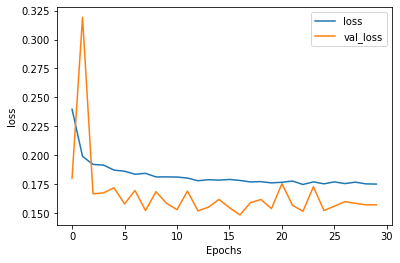

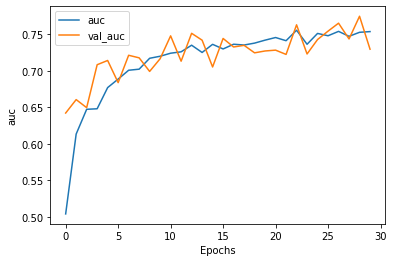

In [23]:
#showing the loss and val_los from the training data
plot_graphs(history, "loss")
#showing accuracy and val_accuracy from the training data 
plot_graphs(history, "auc")

In [24]:
y_pred = model.predict(
    gen_batch(test_data, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [25]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('/content/drive/MyDrive/DM_assignment_6/output.csv')

----
- **Ater performing the model we ralize that the model perform well comparing to the previous trial and this is expected, there is no overfitting or underfitting.** 

----

## **Trial_9**

-----

###**GNN**

In [26]:
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

data = keras.Input(batch_shape=(None,))

edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 8
# parameter message calcualation class
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 8), dtype=tf.float32, name=None), name='gnn_2/StatefulPartitionedCall:0', description="created by layer 'gnn_2'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 8), dtype=tf.float32, name=None), name='tf.math.segment_mean_2/SegmentMean:0', description="created by layer 'tf.math.segment_mean_2'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_2/Sigmoid:0', description="created by layer 'dense_2'")
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None,)]            0           []          

In [27]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [28]:
import math

batch_size = 32
num_batchs = math.ceil(len(training_data) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history = model.fit(
    gen_batch(
        training_data, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 8), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgcn_2/embedding_lookup_grad/Reshape:0", shape=(None, 8), dtype=float32), dense_shape=Tensor("gradients/rgcn_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor o

665/665 [==============================] - 15s 17ms/step - loss: 0.3568 - auc: 0.4397 - val_loss: 0.2352 - val_auc: 0.3442
Epoch 2/30
665/665 [==============================] - 10s 16ms/step - loss: 0.2458 - auc: 0.3759 - val_loss: 0.2202 - val_auc: 0.3562
Epoch 3/30
665/665 [==============================] - 11s 16ms/step - loss: 0.2301 - auc: 0.3831 - val_loss: 0.2081 - val_auc: 0.3531
Epoch 4/30
665/665 [==============================] - 11s 16ms/step - loss: 0.2157 - auc: 0.4201 - val_loss: 0.1987 - val_auc: 0.3665
Epoch 5/30
665/665 [==============================] - 11s 16ms/step - loss: 0.2041 - auc: 0.5097 - val_loss: 0.1758 - val_auc: 0.5299
Epoch 6/30
665/665 [==============================] - 11s 16ms/step - loss: 0.1973 - auc: 0.5842 - val_loss: 0.1749 - val_auc: 0.6169
Epoch 7/30
665/665 [==============================] - 10s 16ms/step - loss: 0.1941 - auc: 0.6137 - val_loss: 0.1630 - val_auc: 0.6470
Epoch 8/30
665/665 [==============================] - 10s 16ms/step - los

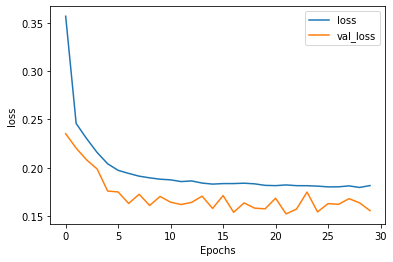

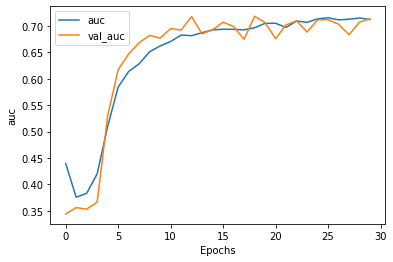

In [29]:
#showing the loss and val_los from the training data
plot_graphs(history, "loss")
#showing accuracy and val_accuracy from the training data 
plot_graphs(history, "auc")

In [30]:
y_pred = model.predict(
    gen_batch(test_data, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [31]:
len(y_pred)

12326

In [32]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('/content/drive/MyDrive/DM_assignment_6/output.csv')

----
- **Ater performing the model we ralize that the model perform well comparing to the previous trial and this is expected, there is no overfitting or underfitting.** 

----

## **Trial_10**

----

### **RGIN**

In [38]:
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

data = keras.Input(batch_shape=(None,))

edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)


params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 64
params["num_aggr_MLP_hidden_layers"] = 32
params['message_calculation_class']= 'RGIN'

gnn_layer = GNN(params)

gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)


avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='gnn_4/StatefulPartitionedCall:0', description="created by layer 'gnn_4'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), name='tf.math.segment_mean_4/SegmentMean:0', description="created by layer 'tf.math.segment_mean_4'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_4/Sigmoid:0', description="created by layer 'dense_4'")
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None,)]            0           []        

In [39]:
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [40]:
import math

batch_size = 32
num_batchs = math.ceil(len(training_data) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

history =model.fit(
    gen_batch(
        training_data, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/cond_3_grad/Identity_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/cond_3_grad/Identity:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/cond_3_grad/Identity_2:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/rgin_2/embedding_lookup_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradients/rgin_2/embedding_lookup_grad/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradients/rgin_2/embedding_lookup_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor

665/665 [==============================] - 228s 322ms/step - loss: 0.5593 - auc: 0.5085 - val_loss: 0.4424 - val_auc: 0.5000
Epoch 2/30
665/665 [==============================] - 257s 386ms/step - loss: 0.3687 - auc: 0.4884 - val_loss: 0.2932 - val_auc: 0.5000
Epoch 3/30
665/665 [==============================] - 215s 324ms/step - loss: 0.2624 - auc: 0.5034 - val_loss: 0.2174 - val_auc: 0.5000
Epoch 4/30
665/665 [==============================] - 231s 348ms/step - loss: 0.2158 - auc: 0.4821 - val_loss: 0.1848 - val_auc: 0.5000
Epoch 5/30
665/665 [==============================] - 236s 354ms/step - loss: 0.2015 - auc: 0.4898 - val_loss: 0.1803 - val_auc: 0.5000
Epoch 6/30
665/665 [==============================] - 237s 356ms/step - loss: 0.1986 - auc: 0.5007 - val_loss: 0.1738 - val_auc: 0.5000
Epoch 7/30
665/665 [==============================] - 230s 346ms/step - loss: 0.1981 - auc: 0.5000 - val_loss: 0.1731 - val_auc: 0.5000
Epoch 8/30
665/665 [==============================] - 258s 

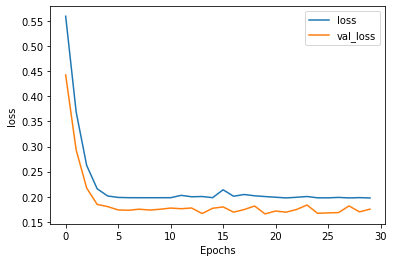

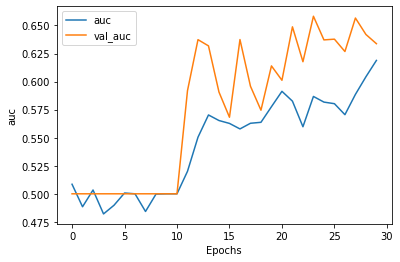

In [41]:
#showing the loss and val_los from the training data
plot_graphs(history, "loss")
#showing accuracy and val_accuracy from the training data 
plot_graphs(history, "auc")

In [42]:
y_pred = model.predict(
    gen_batch(test_data, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

In [43]:
import pandas as pd 
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('/content/drive/MyDrive/DM_assignment_6/output.csv')

----
- **Ater performing the model we ralize that the model perform well comparing to the previous trial and this is expected, there is no overfitting or underfitting.** 

----

#**Questions**

---
**Q.1** : Based on the provided template,describe the format of the input file

----

- SDFs (structure data files) consist of a series of molfiles joined together, together with some additional information about the compounds.Molfiles are text files which contain structure information for a single molecular compound. 
They are frequently used for sharing libraries of compound structure data.A compound record contains several distinct sections. First, there is a three-line header block. These three lines may contain:
 - The name of the molecule
 - Details of the software used to generate the compound structure
 - A comment
 >

\
- Each row of this matrix represents a node of the graph. To assign initial features to each of these nodes, the input layer applies a linear transformation (also called projection) to the one-hot vectors which encode the node representations. Giving a brief recap of the linear transformation.
 >
\

- An SDF file contains a database which is usually called compact relational database. An SDF file contains all the database related information and the SQL Server Compact is a light weight and free database engine which is used to manage the .sdf files. The .sdf file size shouldn’t exceed the limit of 4 GB of size. The SDF files don’t store the information about stored procedures, triggers or views. Applications using an SQL CE database need not specify the path to an SDF file in the ADO.NET connection string, instead it can be mentioned as |DataDirectory|\database_name.sdf, defining the data directory being defined in the assembly manifest for the application The .sdf naming convention is optional, and any extension can be used to save the file. Setting up a password for the database file is an optional step. To compress or repair the database the file should be saved with the option of the




----

**Q.2** : **What are the input tensors to the neural network model (their meaning, not just symbol)? What is each of their dims and their meaning (e.g. batch_size)?**

----

```
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)
```
>  

- node_features= embeded 
  - the first input contains a vector of the words after we change it by using the function Embadding, And the output dimention is 20 
  >

- adjacency_lists=(edge)
  - the edges are what conects one nodes , their dimention is an arry of two values .
>

- node_to_graph_map=node2graph
  - shows how max_nodes_len,number of edges on one batch 
>
- num_graphs=num_graph
  - number of samples, their dimention is n+1


 
  
 * *name:*	
    * it is An optional name string for the layer. 
    * Should be unique in a model (do not reuse the same name twice).
    * It will be autogenerated if it isn't provided.

* *dtype:*
    *	The data type expected by the input, as a string (float32, float64, int32...)

* *batch_size:*	
    * optional static batch size (integer).

* **sparse:** 
    * A boolean specifying whether the placeholder to be created is sparse. Only one of 'ragged' and 'sparse' can be True.
    
* *tensor:* 
    * Optional existing tensor to wrap into the Input layer. If set, the layer will not create a placeholder tensor.


  * *ragged:*
    * A boolean specifying whether the placeholder to be created is ragged. Only one of 'ragged' and 'sparse' can be True.
    * In this case, values of 'None' in the 'shape' argument represent ragged dimensions


 * *shape:*
    * A shape tuple (integers).
    * not including the batch size.
    * Elements of this tuple can be None; 'None' elements represent dimensions where the shape is not known.

----
**Q.3** : **For each dim of gnn_out , what does it symbolize? For each dim of `avg`, what does it symbolize?**

----


`GNNInput`:  **named tuple as input, which encapsulates initial node features, adjacency lists, and auxiliary information.**

- **`hidden_dim`** : sets the size of the output of all message passing layers.

- **`layer_input_dropout_rate`** : sets the dropout rate (during training) for the input of each message passing layer.

- **`residual_every_num_layers`** : sets how often a residual connection is inserted between message passing layers. Concretely, a value of k means that every layer l that is a multiple of k (and only those!) will not receive the outputs of layer l-1 as input, but instead the mean of the outputs of layers l-1 and l-k.

- **`use_inter_layer_layernorm`** : is a boolean flag indicating if LayerNorm should be used between different message passing layers.

- **`dense_every_num_layers`** : configures how often a per-node representation dense layer is inserted between the message passing layers. Setting this to a large value (greather than "num_layers") means that no dense layers are inserted at all.

- **`dense_intermediate_layer_activation`** : configures the activation function used after the dense layer; the default of "tanh" can help stabilise training of very deep GNNs.

- **`global_exchange_every_num_layers`**  : configures how often a graph-level exchange of information is performed. For this, a graph level representation (see tf2_gnn.layers.NodesToGraphRepresentation below) is computed and then used to update the representation of each node. The style of this update is configured by "global_exchange_mode", offering three modes:

- **`mean`**, : which just computes the arithmetic mean of the node and graph-level representation.


- **`mlp`**, : which computes a new representation using an MLP that gets the concatenation of node and graph level representations as input.

- **`gru`**, : which uses a GRU cell that gets the old node representation as state and the graph representation as input.

**avg**


- **`data`** : A Tensor. Must be one of the following types: float32, float64, int32, uint8, int16, int8, complex64, int64, qint8, quint8, qint32, bfloat16, uint16, complex128, half, uint32, uint64.

- **`segment_ids`** : A Tensor. Must be one of the following types: int32, int64. A 1-D tensor whose size is equal to the size of data's first dimension. Values should be sorted and can be repeated.

- **`name`** : A name for the operation (optional).

---
Q.4 : **What is the difference between segment_mean and tf.reduce_mean? For each dim of pred, what does it symbolize?**

---

**segment_mean**


- **data** :	A Tensor. Must be one of the following types: float32, float64, int32, uint8, int16, int8, complex64, int64, qint8, quint8, qint32, bfloat16, uint16, complex128, half, uint32, uint64.

- **segment_ids**	: A Tensor. Must be one of the following types: int32, int64. A 1-D tensor whose size is equal to the size of data's first dimension. Values should be sorted and can be repeated.

- **name** :	A name for the operation (optional).

-----

**tf.reduce_mean**

tensorflow.reduce_mean is the same as numpy.mean. It creates an operation in the underlying tensorflow graph which computes the mean of a tensor.



**input_tensor** :	The tensor to reduce. Should have numeric type.
>
**axis** :	The dimensions to reduce. If None (the default), reduces all dimensions. Must be in the range [-rank(input_tensor),rank(input_tensor)).

>
**keepdims** :	If true, retains reduced dimensions with length 1.
name	A name for the operation (optional).

--- 
**What is the motivation/theory/idea to use multiple gcn layers comparing to just one? How many layers were used in the template?**

---

Expanding the neighbourhood for label propagation by adding multiple GCN layers can improve
geolocation by accessing information from friends
that are multiple hops away, but it might also lead
to propagation of noisy information to users from
an exponentially increasing number of expanded
neighbourhood members. To control the required
balance of how much neighbourhood information
should be passed to a node, we use layer-wise gates
similar to highway networks.

>
>

**there is two layers used in the template.** 

**refreance**

- https://towardsdatascience.com/a-beginners-guide-to-artificial-neural-network-using-tensor-flow-keras-41ccd575a876

- https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

- https://www.tensorflow.org/api_docs/python/tf/math/segment_mean

- https://www.tensorflow.org/api_docs/python/tf/math/reduce_mean

- https://github.com/microsoft/tf2-gnn/blob/master/README.md#schlichtkrull-et-al-2017

- https://towardsdatascience.com/understanding-the-building-blocks-of-graph-neural-networks-intro-56627f0719d5

- https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/